In [1]:
#Importation des librairies
import warnings
warnings.filterwarnings("ignore")

import os
import re
import glob
import pandas as pd
import missingno as msno
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame
import folium
from sklearn import preprocessing
from sklearn import utils
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from yellowbrick.regressor import ResidualsPlot, prediction_error

from time import time

pd.set_option("display.max_columns", None)
pd.options.display.float_format = "{:,.2f}".format

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
def rmpse(y_true, y_pred):
    '''
    Compute Root Mean Square Percentage Error between two arrays.
    '''
    loss = np.sqrt(np.mean(np.square(((y_true - y_pred) / y_true))))

    return loss

def regression_metrics(y_test, y_pred):
    """Function which contains differents metrics about regression
    Input: y_test, prediction
    
    Output: MAE, MSE, RMSE, MAPE & R² score  
    """
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r_score = r2_score(y_test, y_pred, multioutput="variance_weighted")
    print("MAE: ",mae.round(5))
    print("MSE: ", mse.round(5))
    print("RMSE: ", rmse)
    print("R²: ", r_score.round(5))

In [3]:
df = pd.read_csv("projet3.csv", sep=',')

In [4]:
df.shape

(1050, 18)

In [5]:
categorical = [var for var in df.columns if df[var].dtype=='O']

print('There are {} categorical variables\n'.format(len(categorical)))

print('The categorical variables are :\n\n', categorical)

There are 4 categorical variables

The categorical variables are :

 ['PrimaryPropertyType', 'LargestPropertyUseType', 'SecondLargestPropertyUseType', 'ThirdLargestPropertyUseType']


In [6]:
df[categorical].head()

,PrimaryPropertyType,LargestPropertyUseType,SecondLargestPropertyUseType,ThirdLargestPropertyUseType
0,Hotel,Hotel,NaN,NaN
1,Hotel,Hotel,Parking,Restaurant
2,Hotel,Hotel,NaN,NaN
3,Hotel,Hotel,NaN,NaN
4,Hotel,Hotel,Parking,Swimming Pool


In [7]:
for var in categorical: 
    
    print(df[var].value_counts())

Small- and Mid-Sized Office    235
Large Office                   156
Warehouse                      143
K-12 School                    124
Retail Store                    78
Hotel                           72
Worship Facility                63
Distribution Center             40
Supermarket / Grocery Store     38
Medical Office                  37
Mixed Use Property              18
Senior Care Community           18
Other                           11
Hospital                         9
Refrigerated Warehouse           5
Office                           3
Name: PrimaryPropertyType, dtype: int64
Office                                   401
Non-Refrigerated Warehouse               145
K-12 School                              124
Retail Store                              78
Hotel                                     72
Worship Facility                          63
Distribution Center                       41
Medical Office                            37
Supermarket/Grocery Store               

In [8]:
for var in categorical:
    
     print(df[var].value_counts()/np.float(len(df)))

Small- and Mid-Sized Office   0.22
Large Office                  0.15
Warehouse                     0.14
K-12 School                   0.12
Retail Store                  0.07
Hotel                         0.07
Worship Facility              0.06
Distribution Center           0.04
Supermarket / Grocery Store   0.04
Medical Office                0.04
Mixed Use Property            0.02
Senior Care Community         0.02
Other                         0.01
Hospital                      0.01
Refrigerated Warehouse        0.00
Office                        0.00
Name: PrimaryPropertyType, dtype: float64
Office                                  0.38
Non-Refrigerated Warehouse              0.14
K-12 School                             0.12
Retail Store                            0.07
Hotel                                   0.07
Worship Facility                        0.06
Distribution Center                     0.04
Medical Office                          0.04
Supermarket/Grocery Store             

In [9]:
df['TotalGHGEmissions_log'].isnull().sum()

0

In [10]:
df['TotalGHGEmissions_log'].nunique()

1018

In [11]:
df.shape

(1050, 18)

In [12]:
numerical = [var for var in df.columns if df[var].dtype!='O']

print('There are {} numerical variables\n'.format(len(numerical)))

print('The numerical variables are :\n\n', numerical)

There are 14 numerical variables

The numerical variables are :

 ['NumberofBuildings', 'NumberofFloors', 'PropertyGFAParking', 'PropertyGFABuilding(s)', 'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA', 'ENERGYSTARScore', 'SiteEnergyUse(kBtu)', 'TotalGHGEmissions', 'SiteEnergyUse(kBtu)_log', 'TotalGHGEmissions_log', 'SteamUse(kBtu)_binary', 'NaturalGas(kBtu)_binary']


In [13]:
df[numerical].head()

,NumberofBuildings,NumberofFloors,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEnergyUse(kBtu),TotalGHGEmissions,SiteEnergyUse(kBtu)_log,TotalGHGEmissions_log,SteamUse(kBtu)_binary,NaturalGas(kBtu)_binary
0,1.00,12,0,88434,"88,434.00",0.00,0.00,60.00,"7,226,362.50",249.98,15.79,5.52,1,1
1,1.00,11,15064,88502,"83,880.00","15,064.00","4,622.00",61.00,"8,387,933.00",295.86,15.94,5.69,0,1
2,1.00,41,196718,759392,"756,493.00",0.00,0.00,43.00,"72,587,024.00","2,089.28",18.10,7.64,1,1
3,1.00,10,0,61320,"61,320.00",0.00,0.00,56.00,"6,794,584.00",286.43,15.73,5.66,1,1
4,1.00,18,62000,113580,"123,445.00","68,009.00",0.00,75.00,"14,172,606.00",505.01,16.47,6.22,0,1


In [14]:
df[numerical].isnull().sum()

NumberofBuildings                  0
NumberofFloors                     0
PropertyGFAParking                 0
PropertyGFABuilding(s)             0
LargestPropertyUseTypeGFA          0
SecondLargestPropertyUseTypeGFA    0
ThirdLargestPropertyUseTypeGFA     0
ENERGYSTARScore                    0
SiteEnergyUse(kBtu)                0
TotalGHGEmissions                  0
SiteEnergyUse(kBtu)_log            0
TotalGHGEmissions_log              0
SteamUse(kBtu)_binary              0
NaturalGas(kBtu)_binary            0
dtype: int64

# Prédiction des émissions de CO2 avec ENERGYSTARScore

In [15]:
X = df.drop(['TotalGHGEmissions_log','TotalGHGEmissions','SiteEnergyUse(kBtu)_log','SiteEnergyUse(kBtu)'], axis=1)

y = df['TotalGHGEmissions_log']

In [16]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

In [17]:
X_train.shape, X_test.shape

((735, 14), (315, 14))

In [18]:
categorical = [col for col in X_train.columns if X_train[col].dtypes == 'O']

categorical

['PrimaryPropertyType',
 'LargestPropertyUseType',
 'SecondLargestPropertyUseType',
 'ThirdLargestPropertyUseType']

In [19]:
numerical = [col for col in X_train.columns if X_train[col].dtypes != 'O']

numerical

['NumberofBuildings',
 'NumberofFloors',
 'PropertyGFAParking',
 'PropertyGFABuilding(s)',
 'LargestPropertyUseTypeGFA',
 'SecondLargestPropertyUseTypeGFA',
 'ThirdLargestPropertyUseTypeGFA',
 'ENERGYSTARScore',
 'SteamUse(kBtu)_binary',
 'NaturalGas(kBtu)_binary']

In [20]:
X_train[categorical].isnull().mean()

PrimaryPropertyType            0.00
LargestPropertyUseType         0.00
SecondLargestPropertyUseType   0.52
ThirdLargestPropertyUseType    0.86
dtype: float64

In [21]:
X_train.isnull().sum()

PrimaryPropertyType                  0
NumberofBuildings                    0
NumberofFloors                       0
PropertyGFAParking                   0
PropertyGFABuilding(s)               0
LargestPropertyUseType               0
LargestPropertyUseTypeGFA            0
SecondLargestPropertyUseType       383
SecondLargestPropertyUseTypeGFA      0
ThirdLargestPropertyUseType        631
ThirdLargestPropertyUseTypeGFA       0
ENERGYSTARScore                      0
SteamUse(kBtu)_binary                0
NaturalGas(kBtu)_binary              0
dtype: int64

In [22]:
X_test.isnull().sum()

PrimaryPropertyType                  0
NumberofBuildings                    0
NumberofFloors                       0
PropertyGFAParking                   0
PropertyGFABuilding(s)               0
LargestPropertyUseType               0
LargestPropertyUseTypeGFA            0
SecondLargestPropertyUseType       188
SecondLargestPropertyUseTypeGFA      0
ThirdLargestPropertyUseType        274
ThirdLargestPropertyUseTypeGFA       0
ENERGYSTARScore                      0
SteamUse(kBtu)_binary                0
NaturalGas(kBtu)_binary              0
dtype: int64

In [23]:
import category_encoders as ce

In [24]:
encoder = ce.OneHotEncoder(cols=['PrimaryPropertyType',
 'LargestPropertyUseType',
 'SecondLargestPropertyUseType',
 'ThirdLargestPropertyUseType'])

X_train = encoder.fit_transform(X_train)

X_test = encoder.transform(X_test)

In [25]:
X_test.head()

,PrimaryPropertyType_1,PrimaryPropertyType_2,PrimaryPropertyType_3,PrimaryPropertyType_4,PrimaryPropertyType_5,PrimaryPropertyType_6,PrimaryPropertyType_7,PrimaryPropertyType_8,PrimaryPropertyType_9,PrimaryPropertyType_10,PrimaryPropertyType_11,PrimaryPropertyType_12,PrimaryPropertyType_13,PrimaryPropertyType_14,PrimaryPropertyType_15,PrimaryPropertyType_16,NumberofBuildings,NumberofFloors,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseType_1,LargestPropertyUseType_2,LargestPropertyUseType_3,LargestPropertyUseType_4,LargestPropertyUseType_5,LargestPropertyUseType_6,LargestPropertyUseType_7,LargestPropertyUseType_8,LargestPropertyUseType_9,LargestPropertyUseType_10,LargestPropertyUseType_11,LargestPropertyUseType_12,LargestPropertyUseType_13,LargestPropertyUseType_14,LargestPropertyUseType_15,LargestPropertyUseType_16,LargestPropertyUseType_17,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType_1,SecondLargestPropertyUseType_2,SecondLargestPropertyUseType_3,SecondLargestPropertyUseType_4,SecondLargestPropertyUseType_5,SecondLargestPropertyUseType_6,SecondLargestPropertyUseType_7,SecondLargestPropertyUseType_8,SecondLargestPropertyUseType_9,SecondLargestPropertyUseType_10,SecondLargestPropertyUseType_11,SecondLargestPropertyUseType_12,SecondLargestPropertyUseType_13,SecondLargestPropertyUseType_14,SecondLargestPropertyUseType_15,SecondLargestPropertyUseType_16,SecondLargestPropertyUseType_17,SecondLargestPropertyUseType_18,SecondLargestPropertyUseType_19,SecondLargestPropertyUseType_20,SecondLargestPropertyUseType_21,SecondLargestPropertyUseType_22,SecondLargestPropertyUseType_23,SecondLargestPropertyUseType_24,SecondLargestPropertyUseType_25,SecondLargestPropertyUseType_26,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType_1,ThirdLargestPropertyUseType_2,ThirdLargestPropertyUseType_3,ThirdLargestPropertyUseType_4,ThirdLargestPropertyUseType_5,ThirdLargestPropertyUseType_6,ThirdLargestPropertyUseType_7,ThirdLargestPropertyUseType_8,ThirdLargestPropertyUseType_9,ThirdLargestPropertyUseType_10,ThirdLargestPropertyUseType_11,ThirdLargestPropertyUseType_12,ThirdLargestPropertyUseType_13,ThirdLargestPropertyUseType_14,ThirdLargestPropertyUseType_15,ThirdLargestPropertyUseType_16,ThirdLargestPropertyUseType_17,ThirdLargestPropertyUseType_18,ThirdLargestPropertyUseType_19,ThirdLargestPropertyUseType_20,ThirdLargestPropertyUseType_21,ThirdLargestPropertyUseType_22,ThirdLargestPropertyUseType_23,ThirdLargestPropertyUseType_24,ThirdLargestPropertyUseType_25,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SteamUse(kBtu)_binary,NaturalGas(kBtu)_binary
743,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.00,2,0,20671,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"20,671.00",1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,98.00,0,1
656,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.00,1,0,35289,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"35,289.00",1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,63.00,0,1
704,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.00,2,0,27574,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"27,574.00",1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,73.00,0,0
738,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.00,3,21908,35224,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"33,705.00",0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"21,908.00",1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,73.00,0,0
496,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1.00,1,0,23409,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"21,909.00",0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"1,500.00",1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,67.00,0,1


In [26]:
X_test.shape

(315, 94)

In [27]:
cols = X_train.columns

In [28]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()

X_train = scaler.fit_transform(X_train)

X_test = scaler.transform(X_test)

In [29]:
X_train = pd.DataFrame(X_train, columns=[cols])

In [30]:
X_test = pd.DataFrame(X_test, columns=[cols])

### Dummy Regressor


In [31]:
dummy_reg = DummyRegressor(strategy="median")
dummy_reg.fit(X_train, y_train)

DummyRegressor(strategy='median')

In [32]:
y_pred = dummy_reg.predict(X_test)
regression_metrics(np.array(y_test), y_pred)

MAE:  1.15715
MSE:  2.22531
RMSE:  1.4917473898947993
R²:  -0.00045


In [33]:
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
import xgboost as xgb

dummy_reg = DummyRegressor(strategy="median")
lin_reg = LinearRegression()
lasso = linear_model.Lasso()
ridge = linear_model.Ridge()
gdboost = GradientBoostingRegressor(random_state=10)
rdmforest = RandomForestRegressor(random_state=10)

In [34]:
model = [dummy_reg, lin_reg,lasso,ridge, gdboost, rdmforest]
dict_model = {}

for model in model:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r_score = r2_score(y_test, y_pred, multioutput="variance_weighted").round(3)
    dict_model[model] = (mae.round(3), mse.round(3), rmse.round(3), r_score)

eval_model = pd.DataFrame(dict_model, index=["MAE", "MSE", "RMSE", "R²"])
eval_model.columns = ["Dummy Regressor", "Linear Regression","Lasso", "Ridge", "GradientBoosting", "Random Forest"]

eval_model

,Dummy Regressor,Linear Regression,Lasso,Ridge,GradientBoosting,Random Forest
MAE,1.16,0.68,1.09,0.66,0.52,0.55
MSE,2.23,0.81,1.97,0.73,0.47,0.55
RMSE,1.49,0.90,1.40,0.85,0.68,0.74
R²,-0.00,0.64,0.12,0.67,0.79,0.75


Nous allons maintenant chercher les hyperparamètres pour chaque modèle afin de déterminer lequel sera le plus adapté à notre problème


In [35]:
# instanciation du modèle avec paramètre de base 
linear_reg = LinearRegression(n_jobs=-1)

In [36]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {}

rnd_search = RandomizedSearchCV(linear_reg, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=10)
rnd_search.fit(X_train, y_train)


RandomizedSearchCV(cv=5, estimator=LinearRegression(n_jobs=-1),
                   param_distributions={}, random_state=10,
                   scoring='neg_mean_squared_error')

In [37]:
final_model_energy_linear = rnd_search.best_estimator_

In [38]:
final_predictions_energy = final_model_energy_linear.predict(X_test)

In [39]:
regression_metrics(np.array(y_test), final_predictions_energy)

MAE:  0.68098
MSE:  0.81192
RMSE:  0.9010681812008782
R²:  0.63498


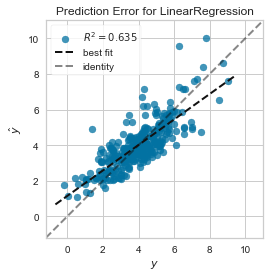

In [40]:
visualizer = prediction_error(final_model_energy_linear, np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test));


In [41]:
lasso = linear_model.Lasso()

In [42]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {'alpha':[0.02, 0.024, 0.025, 0.026, 0.03, 0.1, 0.2, 0.3,0.4, 0.5, 1, 2, 3, 4, 5]}


rnd_search = RandomizedSearchCV(lasso, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=10)
rnd_search.fit(X_train, y_train)


RandomizedSearchCV(cv=5, estimator=Lasso(),
                   param_distributions={'alpha': [0.02, 0.024, 0.025, 0.026,
                                                  0.03, 0.1, 0.2, 0.3, 0.4, 0.5,
                                                  1, 2, 3, 4, 5]},
                   random_state=10, scoring='neg_mean_squared_error')

In [43]:
lasso = rnd_search.best_estimator_

In [44]:
final_predictions_energy = lasso.predict(X_test)

In [45]:
regression_metrics(np.array(y_test), final_predictions_energy)

MAE:  0.72757
MSE:  0.8594
RMSE:  0.9270399537116683
R²:  0.61363


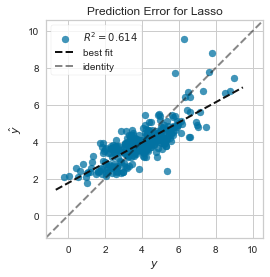

In [46]:
visualizer = prediction_error(lasso, np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test));


In [47]:
ridge = linear_model.Ridge()

In [48]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {'alpha':[200, 230, 250,265, 270, 275, 290, 300, 500]}

rnd_search = RandomizedSearchCV(ridge, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=10)
rnd_search.fit(X_train, y_train)


RandomizedSearchCV(cv=5, estimator=Ridge(),
                   param_distributions={'alpha': [200, 230, 250, 265, 270, 275,
                                                  290, 300, 500]},
                   random_state=10, scoring='neg_mean_squared_error')

In [49]:
ridge = rnd_search.best_estimator_

In [50]:
final_predictions_energy = ridge.predict(X_test)

In [51]:
regression_metrics(np.array(y_test), final_predictions_energy)

MAE:  0.80227
MSE:  1.05243
RMSE:  1.0258792500342648
R²:  0.52685


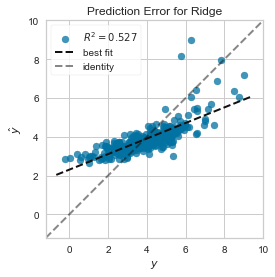

In [52]:
visualizer = prediction_error(ridge, np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test));


In [53]:
# instanciation du modèle avec paramètre de base 
gdboost = GradientBoostingRegressor()

In [54]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
        "n_estimators" : [int(x) for x in np.linspace(start=200, stop=1000, num=10)],
        "max_features" : ["auto", "sqrt"],
        "max_depth": [int(x) for x in np.linspace(start=5, stop=110, num=11)],
        "min_samples_split" : randint(low=2, high=10),
        "min_samples_leaf" : randint(low=2, high=10)
    }
rnd_search = RandomizedSearchCV(gdboost, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=10)
rnd_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=GradientBoostingRegressor(),
                   param_distributions={'max_depth': [5, 15, 26, 36, 47, 57, 68,
                                                      78, 89, 99, 110],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002685F97FA60>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000268609F13D0>,
                                        'n_estimators': [200, 288, 377, 466,
                                                         555, 644, 733, 822,
                                                         911, 1000]},
                   random_state=10, scoring='neg_mean_squared_error')

In [55]:
rnd_search.best_params_

{'max_depth': 99,
 'max_features': 'sqrt',
 'min_samples_leaf': 6,
 'min_samples_split': 9,
 'n_estimators': 200}

In [56]:
final_model_energy_gdboost = rnd_search.best_estimator_

In [57]:
final_predictions_energy = final_model_energy_gdboost.predict(X_test)

In [58]:
regression_metrics(np.array(y_test), final_predictions_energy)

MAE:  0.53459
MSE:  0.48898
RMSE:  0.6992683781466728
R²:  0.78017


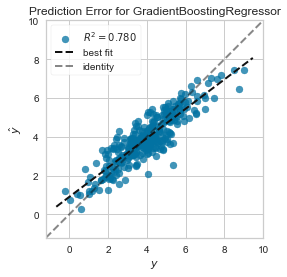

In [59]:
visualizer = prediction_error(final_model_energy_gdboost, np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test));


In [60]:
from sklearn.ensemble import RandomForestRegressor

regressor = RandomForestRegressor(n_estimators = 100, random_state = 0)

# fit the regressor with x and y data
regressor.fit(X_train, y_train)

# Predict the Test set results
y_pred = regressor.predict(X_test)


In [61]:
# instanciation du modèle avec paramètre de base 
forest_reg = RandomForestRegressor(random_state=10, n_jobs=-1)

In [62]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
        "n_estimators" : [int(x) for x in np.linspace(start=200, stop=1000, num=10)],
        "max_features" : ["auto", "sqrt"],
        "max_depth": [int(x) for x in np.linspace(start=5, stop=110, num=11)],
        "min_samples_split" : randint(low=2, high=10),
        "min_samples_leaf" : randint(low=2, high=10),
        "bootstrap" : [True, False]
    }

rnd_search = RandomizedSearchCV(regressor, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=10)
rnd_search.fit(X_train, y_train)


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=0),
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [5, 15, 26, 36, 47, 57, 68,
                                                      78, 89, 99, 110],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000268609F12E0>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000268609F1C10>,
                                        'n_estimators': [200, 288, 377, 466,
                                                         555, 644, 733, 822,
                                                         911, 1000]},
                   random_state=10, scoring='neg_mean_squared_error')

In [63]:
rnd_search.best_params_

{'bootstrap': True,
 'max_depth': 110,
 'max_features': 'auto',
 'min_samples_leaf': 3,
 'min_samples_split': 2,
 'n_estimators': 555}

In [64]:
'''from sklearn.model_selection import GridSearchCV

params = [{"bootstrap":[True],
           "max_depth" : [79, 89, 99, 109, 119, 129],
           "max_features" : ["auto"],
           "min_samples_leaf" : [2, 3, 4],
           "min_samples_split" : [2,3,4],
           "n_estimators" : [900, 1000, 1100]
}]

grid_search = GridSearchCV(forest_reg, params, cv=5,
                           scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)'''

'from sklearn.model_selection import GridSearchCV\n\nparams = [{"bootstrap":[True],\n           "max_depth" : [79, 89, 99, 109, 119, 129],\n           "max_features" : ["auto"],\n           "min_samples_leaf" : [2, 3, 4],\n           "min_samples_split" : [2,3,4],\n           "n_estimators" : [900, 1000, 1100]\n}]\n\ngrid_search = GridSearchCV(forest_reg, params, cv=5,\n                           scoring=\'neg_mean_squared_error\')\ngrid_search.fit(X_train, y_train)'

In [65]:
#grid_search.best_params_

In [66]:
final_model_energy_forest = rnd_search.best_estimator_

In [67]:
final_predictions_energy = final_model_energy_forest.predict(X_test)

In [68]:
regression_metrics(np.array(y_test), final_predictions_energy)

MAE:  0.56633
MSE:  0.56856
RMSE:  0.7540305405106967
R²:  0.74439


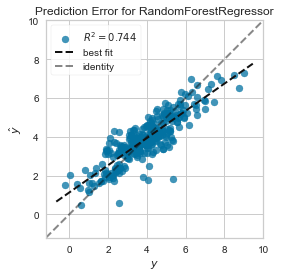

In [69]:
visualizer = prediction_error(final_model_energy_forest, np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test));


In [70]:
feature_importances_forest = pd.DataFrame(final_model_energy_forest.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)

feature_importances_gradient = pd.DataFrame(final_model_energy_gdboost.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)

In [71]:
pd.set_option("display.max_rows", None, "display.max_columns", None)
feature_importances_forest.head()

,importance
LargestPropertyUseTypeGFA,0.26
PropertyGFABuilding(s),0.25
NaturalGas(kBtu)_binary,0.19
ENERGYSTARScore,0.11
NumberofFloors,0.04


In [72]:
pd.set_option("display.max_rows", None, "display.max_columns", None)
feature_importances_gradient.head()

,importance
LargestPropertyUseTypeGFA,0.22
NaturalGas(kBtu)_binary,0.17
PropertyGFABuilding(s),0.11
ENERGYSTARScore,0.10
NumberofFloors,0.09


# Prédiction des émissions de CO2 sans ENERGYSTARScore

In [73]:
df = pd.read_csv("projet3.csv", sep=',')

X = df.drop(['TotalGHGEmissions_log','TotalGHGEmissions','SiteEnergyUse(kBtu)_log','SiteEnergyUse(kBtu)','ENERGYSTARScore'], axis=1)
y = df['TotalGHGEmissions_log']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

encoder = ce.OneHotEncoder(cols=['PrimaryPropertyType',
 'LargestPropertyUseType',
 'SecondLargestPropertyUseType',
 'ThirdLargestPropertyUseType'])

X_train = encoder.fit_transform(X_train)

X_test = encoder.transform(X_test)

cols = X_train.columns

scaler = RobustScaler()

X_train = scaler.fit_transform(X_train)

X_test = scaler.transform(X_test)

In [74]:
X_train = pd.DataFrame(X_train, columns=[cols])

In [75]:
X_test = pd.DataFrame(X_test, columns=[cols])

In [76]:
dummy_reg = DummyRegressor(strategy="median")
dummy_reg.fit(X_train, y_train)
y_pred = dummy_reg.predict(X_test)
regression_metrics(np.array(y_test), y_pred)

MAE:  1.15715
MSE:  2.22531
RMSE:  1.4917473898947993
R²:  -0.00045


In [77]:
dummy_reg = DummyRegressor(strategy="median")
lin_reg = LinearRegression()
lasso = linear_model.Lasso()
ridge = linear_model.Ridge()
gdboost = GradientBoostingRegressor(random_state=10)
rdmforest = RandomForestRegressor(random_state=10)

In [78]:
model = [dummy_reg, lin_reg,lasso,ridge, gdboost, rdmforest]
dict_model = {}

for model in model:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r_score = r2_score(y_test, y_pred, multioutput="variance_weighted").round(3)
    dict_model[model] = (mae.round(3), mse.round(3), rmse.round(3), r_score)

eval_model = pd.DataFrame(dict_model, index=["MAE", "MSE", "RMSE", "R²"])
eval_model.columns = ["Dummy Regressor", "Linear Regression","Lasso", "Ridge", "GradientBoosting", "Random Forest"]

eval_model

,Dummy Regressor,Linear Regression,Lasso,Ridge,GradientBoosting,Random Forest
MAE,1.16,0.73,1.09,0.71,0.58,0.62
MSE,2.23,0.93,1.97,0.84,0.61,0.69
RMSE,1.49,0.96,1.40,0.92,0.78,0.83
R²,-0.00,0.58,0.12,0.62,0.73,0.69


In [79]:
# instanciation du modèle avec paramètre de base 
linear_reg = LinearRegression(n_jobs=-1)

In [80]:
param_distribs = {}

rnd_search = RandomizedSearchCV(linear_reg, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=10)
rnd_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=LinearRegression(n_jobs=-1),
                   param_distributions={}, random_state=10,
                   scoring='neg_mean_squared_error')

In [81]:
final_model_energy_linear = rnd_search.best_estimator_
final_predictions_energy = final_model_energy_linear.predict(X_test)
regression_metrics(np.array(y_test), final_predictions_energy)

MAE:  0.73167
MSE:  0.92844
RMSE:  0.9635560905970374
R²:  0.58259


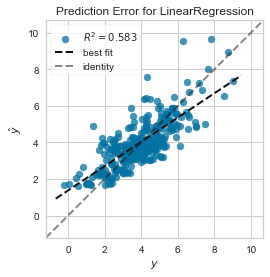

In [82]:
visualizer = prediction_error(final_model_energy_linear, np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test));


In [83]:
lasso = linear_model.Lasso()

In [84]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {'alpha':[0.02, 0.024, 0.025, 0.026, 0.03, 0.1, 0.2, 0.3,0.4, 0.5, 1, 2, 3, 4, 5]}


rnd_search = RandomizedSearchCV(lasso, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=10)
rnd_search.fit(X_train, y_train)


RandomizedSearchCV(cv=5, estimator=Lasso(),
                   param_distributions={'alpha': [0.02, 0.024, 0.025, 0.026,
                                                  0.03, 0.1, 0.2, 0.3, 0.4, 0.5,
                                                  1, 2, 3, 4, 5]},
                   random_state=10, scoring='neg_mean_squared_error')

In [85]:
lasso = rnd_search.best_estimator_

In [86]:
final_predictions_energy = lasso.predict(X_test)

In [87]:
regression_metrics(np.array(y_test), final_predictions_energy)

MAE:  0.77274
MSE:  0.96815
RMSE:  0.9839468841892813
R²:  0.56474


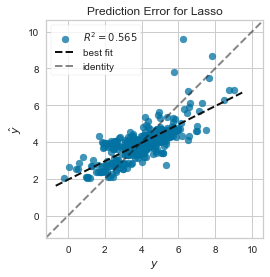

In [88]:
visualizer = prediction_error(lasso, np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test));


In [89]:
ridge = linear_model.Ridge()

In [90]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {'alpha':[200, 230, 250,265, 270, 275, 290, 300, 500]}

rnd_search = RandomizedSearchCV(ridge, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=10)
rnd_search.fit(X_train, y_train)


RandomizedSearchCV(cv=5, estimator=Ridge(),
                   param_distributions={'alpha': [200, 230, 250, 265, 270, 275,
                                                  290, 300, 500]},
                   random_state=10, scoring='neg_mean_squared_error')

In [91]:
ridge = rnd_search.best_estimator_

In [92]:
final_predictions_energy = ridge.predict(X_test)

In [93]:
regression_metrics(np.array(y_test), final_predictions_energy)

MAE:  0.84091
MSE:  1.14607
RMSE:  1.0705481842558193
R²:  0.48475


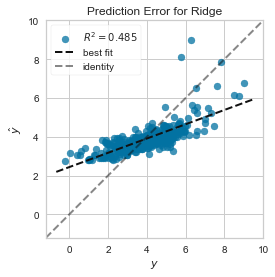

In [94]:
visualizer = prediction_error(ridge, np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test));


In [95]:
gdboost = GradientBoostingRegressor()
param_distribs = {
        "n_estimators" : [int(x) for x in np.linspace(start=200, stop=1000, num=10)],
        "max_features" : ["auto", "sqrt"],
        "max_depth": [int(x) for x in np.linspace(start=5, stop=110, num=11)],
        "min_samples_split" : randint(low=2, high=10),
        "min_samples_leaf" : randint(low=2, high=10)
    }
rnd_search = RandomizedSearchCV(gdboost, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=10)
rnd_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=GradientBoostingRegressor(),
                   param_distributions={'max_depth': [5, 15, 26, 36, 47, 57, 68,
                                                      78, 89, 99, 110],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002685C0D3310>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002685C0D3520>,
                                        'n_estimators': [200, 288, 377, 466,
                                                         555, 644, 733, 822,
                                                         911, 1000]},
                   random_state=10, scoring='neg_mean_squared_error')

In [96]:
final_model_energy_gdboost = rnd_search.best_estimator_
final_predictions_energy = final_model_energy_gdboost.predict(X_test)
regression_metrics(np.array(y_test), final_predictions_energy)

MAE:  0.61539
MSE:  0.68367
RMSE:  0.8268436038603205
R²:  0.69264


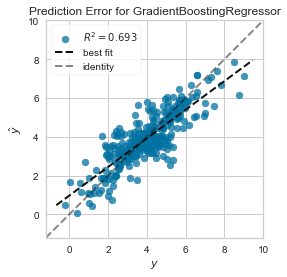

In [97]:
visualizer = prediction_error(final_model_energy_gdboost, np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test));


In [98]:
forest_reg = RandomForestRegressor(random_state=10, n_jobs=-1)
param_distribs = {
        "n_estimators" : [int(x) for x in np.linspace(start=200, stop=1000, num=10)],
        "max_features" : ["auto", "sqrt"],
        "max_depth": [int(x) for x in np.linspace(start=5, stop=110, num=11)],
        "min_samples_split" : randint(low=2, high=10),
        "min_samples_leaf" : randint(low=2, high=10),
        "bootstrap" : [True, False]
    }

rnd_search = RandomizedSearchCV(regressor, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=10)
rnd_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=0),
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [5, 15, 26, 36, 47, 57, 68,
                                                      78, 89, 99, 110],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002685F9328E0>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002685F934F40>,
                                        'n_estimators': [200, 288, 377, 466,
                                                         555, 644, 733, 822,
                                                         911, 1000]},
                   random_state=10, scoring='neg_mean_squared_error')

In [99]:
final_model_energy_forest = rnd_search.best_estimator_
final_predictions_energy = final_model_energy_forest.predict(X_test)
regression_metrics(np.array(y_test), final_predictions_energy)

MAE:  0.61821
MSE:  0.66103
RMSE:  0.813037269753544
R²:  0.70282


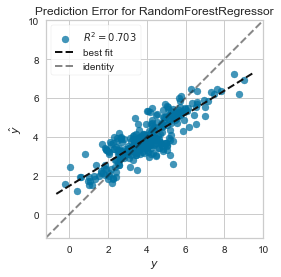

In [100]:
visualizer = prediction_error(final_model_energy_forest, np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test));


In [101]:
feature_importances_forest = pd.DataFrame(final_model_energy_forest.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)

feature_importances_gradient = pd.DataFrame(final_model_energy_gdboost.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)

In [102]:
pd.set_option("display.max_rows", None, "display.max_columns", None)
feature_importances_forest.head()

,importance
PropertyGFABuilding(s),0.19
LargestPropertyUseTypeGFA,0.18
NaturalGas(kBtu)_binary,0.17
NumberofFloors,0.07
SecondLargestPropertyUseTypeGFA,0.06


In [103]:
pd.set_option("display.max_rows", None, "display.max_columns", None)
feature_importances_gradient.head()

,importance
PropertyGFABuilding(s),0.24
LargestPropertyUseTypeGFA,0.19
NaturalGas(kBtu)_binary,0.16
NumberofFloors,0.04
SecondLargestPropertyUseTypeGFA,0.04


# Prédiction de consommation énergétique avec ENERGYSTARScore

In [104]:
df = pd.read_csv("projet3.csv", sep=',')

X = df.drop(['TotalGHGEmissions_log','TotalGHGEmissions','SiteEnergyUse(kBtu)_log','SiteEnergyUse(kBtu)'], axis=1)
y = df['SiteEnergyUse(kBtu)_log']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

encoder = ce.OneHotEncoder(cols=['PrimaryPropertyType',
 'LargestPropertyUseType',
 'SecondLargestPropertyUseType',
 'ThirdLargestPropertyUseType'])

X_train = encoder.fit_transform(X_train)

X_test = encoder.transform(X_test)

cols = X_train.columns

scaler = RobustScaler()

X_train = scaler.fit_transform(X_train)

X_test = scaler.transform(X_test)

X_train = pd.DataFrame(X_train, columns=[cols])
X_test = pd.DataFrame(X_test, columns=[cols])

dummy_reg = DummyRegressor(strategy="median")
dummy_reg.fit(X_train, y_train)
y_pred = dummy_reg.predict(X_test)
regression_metrics(np.array(y_test), y_pred)

MAE:  0.99894
MSE:  1.63439
RMSE:  1.2784327431976918
R²:  -0.00342


In [105]:
dummy_reg = DummyRegressor(strategy="median")
lin_reg = LinearRegression()
lasso = linear_model.Lasso()
ridge = linear_model.Ridge()
gdboost = GradientBoostingRegressor(random_state=10)
rdmforest = RandomForestRegressor(random_state=10)

In [106]:
model = [dummy_reg, lin_reg,lasso,ridge, gdboost, rdmforest]
dict_model = {}

for model in model:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r_score = r2_score(y_test, y_pred, multioutput="variance_weighted").round(3)
    dict_model[model] = (mae.round(3), mse.round(3), rmse.round(3), r_score)

eval_model = pd.DataFrame(dict_model, index=["MAE", "MSE", "RMSE", "R²"])
eval_model.columns = ["Dummy Regressor", "Linear Regression","Lasso", "Ridge", "GradientBoosting", "Random Forest"]

eval_model

,Dummy Regressor,Linear Regression,Lasso,Ridge,GradientBoosting,Random Forest
MAE,1.00,0.53,0.87,0.52,0.35,0.38
MSE,1.63,0.52,1.27,0.47,0.26,0.31
RMSE,1.28,0.72,1.13,0.69,0.51,0.55
R²,-0.00,0.68,0.22,0.71,0.84,0.81


In [107]:
# instanciation du modèle avec paramètre de base 
linear_reg = LinearRegression(n_jobs=-1)

In [108]:
param_distribs = {}

rnd_search = RandomizedSearchCV(linear_reg, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=10)
rnd_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=LinearRegression(n_jobs=-1),
                   param_distributions={}, random_state=10,
                   scoring='neg_mean_squared_error')

In [109]:
final_model_energy_linear = rnd_search.best_estimator_
final_predictions_energy = final_model_energy_linear.predict(X_test)
regression_metrics(np.array(y_test), final_predictions_energy)

MAE:  0.52801
MSE:  0.52353
RMSE:  0.7235553283660348
R²:  0.67858


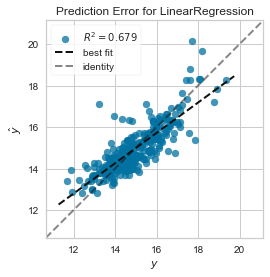

In [110]:
visualizer = prediction_error(final_model_energy_linear, np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test));


In [111]:
lasso = linear_model.Lasso()

In [112]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {'alpha':[0.02, 0.024, 0.025, 0.026, 0.03, 0.1, 0.2, 0.3,0.4, 0.5, 1, 2, 3, 4, 5]}

rnd_search = RandomizedSearchCV(lasso, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=10)
rnd_search.fit(X_train, y_train)


RandomizedSearchCV(cv=5, estimator=Lasso(),
                   param_distributions={'alpha': [0.02, 0.024, 0.025, 0.026,
                                                  0.03, 0.1, 0.2, 0.3, 0.4, 0.5,
                                                  1, 2, 3, 4, 5]},
                   random_state=10, scoring='neg_mean_squared_error')

In [113]:
lasso = rnd_search.best_estimator_

In [114]:
final_predictions_energy = lasso.predict(X_test)

In [115]:
regression_metrics(np.array(y_test), final_predictions_energy)

MAE:  0.59347
MSE:  0.60893
RMSE:  0.7803391111897525
R²:  0.62615


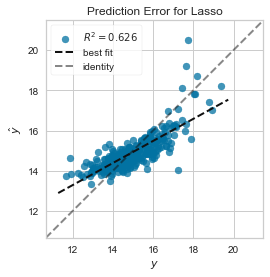

In [116]:
visualizer = prediction_error(lasso, np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test));


In [117]:
ridge = linear_model.Ridge()

In [118]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {'alpha':[200, 230, 250,265, 270, 275, 290, 300, 500]}

rnd_search = RandomizedSearchCV(ridge, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=10)
rnd_search.fit(X_train, y_train)


RandomizedSearchCV(cv=5, estimator=Ridge(),
                   param_distributions={'alpha': [200, 230, 250, 265, 270, 275,
                                                  290, 300, 500]},
                   random_state=10, scoring='neg_mean_squared_error')

In [119]:
ridge = rnd_search.best_estimator_

In [120]:
final_predictions_energy = ridge.predict(X_test)

In [121]:
regression_metrics(np.array(y_test), final_predictions_energy)

MAE:  0.63895
MSE:  0.69794
RMSE:  0.8354274013923636
R²:  0.57151


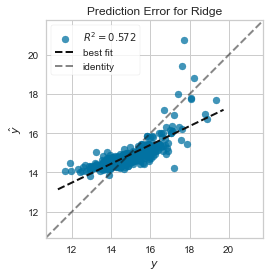

In [122]:
visualizer = prediction_error(ridge, np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test));


In [123]:
gdboost = GradientBoostingRegressor()
param_distribs = {
        "n_estimators" : [int(x) for x in np.linspace(start=200, stop=1000, num=10)],
        "max_features" : ["auto", "sqrt"],
        "max_depth": [int(x) for x in np.linspace(start=5, stop=110, num=11)],
        "min_samples_split" : randint(low=2, high=10),
        "min_samples_leaf" : randint(low=2, high=10)
    }
rnd_search = RandomizedSearchCV(gdboost, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=10)
rnd_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=GradientBoostingRegressor(),
                   param_distributions={'max_depth': [5, 15, 26, 36, 47, 57, 68,
                                                      78, 89, 99, 110],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000026862BE3460>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000026861AEA190>,
                                        'n_estimators': [200, 288, 377, 466,
                                                         555, 644, 733, 822,
                                                         911, 1000]},
                   random_state=10, scoring='neg_mean_squared_error')

In [124]:
final_model_energy_gdboost = rnd_search.best_estimator_
final_predictions_energy = final_model_energy_gdboost.predict(X_test)
regression_metrics(np.array(y_test), final_predictions_energy)

MAE:  0.34936
MSE:  0.26291
RMSE:  0.5127509712465939
R²:  0.83859


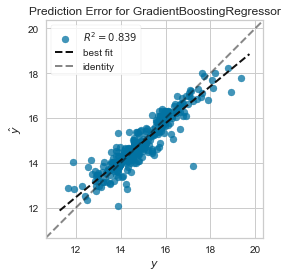

In [125]:
visualizer = prediction_error(final_model_energy_gdboost, np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test));


In [126]:
regressor = RandomForestRegressor(n_estimators = 100, random_state = 0)

# fit the regressor with x and y data
regressor.fit(X_train, y_train)

# Predict the Test set results
y_pred = regressor.predict(X_test)


In [127]:
# instanciation du modèle avec paramètre de base 
forest_reg = RandomForestRegressor(random_state=10, n_jobs=-1)

In [128]:
param_distribs = {
        "n_estimators" : [int(x) for x in np.linspace(start=200, stop=1000, num=10)],
        "max_features" : ["auto", "sqrt"],
        "max_depth": [int(x) for x in np.linspace(start=5, stop=110, num=11)],
        "min_samples_split" : randint(low=2, high=10),
        "min_samples_leaf" : randint(low=2, high=10),
        "bootstrap" : [True, False]
    }

rnd_search = RandomizedSearchCV(regressor, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=10)
rnd_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=0),
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [5, 15, 26, 36, 47, 57, 68,
                                                      78, 89, 99, 110],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000026861AB3070>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002685FA06D60>,
                                        'n_estimators': [200, 288, 377, 466,
                                                         555, 644, 733, 822,
                                                         911, 1000]},
                   random_state=10, scoring='neg_mean_squared_error')

In [129]:
final_model_energy_forest = rnd_search.best_estimator_
final_predictions_energy = final_model_energy_forest.predict(X_test)
regression_metrics(np.array(y_test), final_predictions_energy)

MAE:  0.39615
MSE:  0.32206
RMSE:  0.5675008149210031
R²:  0.80228


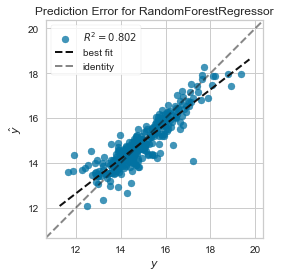

In [130]:
visualizer = prediction_error(final_model_energy_forest, np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test));


In [131]:
feature_importances_forest = pd.DataFrame(final_model_energy_forest.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)

feature_importances_gradient = pd.DataFrame(final_model_energy_gdboost.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)

In [132]:
pd.set_option("display.max_rows", None, "display.max_columns", None)
feature_importances_forest.head()

,importance
PropertyGFABuilding(s),0.42
LargestPropertyUseTypeGFA,0.30
ENERGYSTARScore,0.12
PrimaryPropertyType_2,0.03
LargestPropertyUseType_2,0.02


In [133]:
pd.set_option("display.max_rows", None, "display.max_columns", None)
feature_importances_gradient.head()

,importance
LargestPropertyUseTypeGFA,0.20
PropertyGFABuilding(s),0.16
SecondLargestPropertyUseTypeGFA,0.13
ENERGYSTARScore,0.10
PropertyGFAParking,0.06


# Prédiction de consommation énergétique sans ENERGYSTARScore

In [134]:
df = pd.read_csv("projet3.csv", sep=',')

X = df.drop(['TotalGHGEmissions_log','TotalGHGEmissions','SiteEnergyUse(kBtu)_log','SiteEnergyUse(kBtu)','ENERGYSTARScore'], axis=1)
y = df['SiteEnergyUse(kBtu)_log']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

encoder = ce.OneHotEncoder(cols=['PrimaryPropertyType',
 'LargestPropertyUseType',
 'SecondLargestPropertyUseType',
 'ThirdLargestPropertyUseType'])

X_train = encoder.fit_transform(X_train)

X_test = encoder.transform(X_test)

cols = X_train.columns

scaler = RobustScaler()

X_train = scaler.fit_transform(X_train)

X_test = scaler.transform(X_test)

X_train = pd.DataFrame(X_train, columns=[cols])
X_test = pd.DataFrame(X_test, columns=[cols])

dummy_reg = DummyRegressor(strategy="median")
dummy_reg.fit(X_train, y_train)
y_pred = dummy_reg.predict(X_test)
regression_metrics(np.array(y_test), y_pred)

MAE:  0.99894
MSE:  1.63439
RMSE:  1.2784327431976918
R²:  -0.00342


In [135]:
dummy_reg = DummyRegressor(strategy="median")
lin_reg = LinearRegression()
lasso = linear_model.Lasso()
ridge = linear_model.Ridge()
gdboost = GradientBoostingRegressor(random_state=10)
rdmforest = RandomForestRegressor(random_state=10)

In [136]:
model = [dummy_reg, lin_reg,lasso,ridge, gdboost, rdmforest]
dict_model = {}

for model in model:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r_score = r2_score(y_test, y_pred, multioutput="variance_weighted").round(3)
    dict_model[model] = (mae.round(3), mse.round(3), rmse.round(3), r_score)

eval_model = pd.DataFrame(dict_model, index=["MAE", "MSE", "RMSE", "R²"])
eval_model.columns = ["Dummy Regressor", "Linear Regression","Lasso", "Ridge", "GradientBoosting", "Random Forest"]

eval_model

,Dummy Regressor,Linear Regression,Lasso,Ridge,GradientBoosting,Random Forest
MAE,1.00,0.58,0.87,0.57,0.45,0.46
MSE,1.63,0.62,1.27,0.57,0.38,0.44
RMSE,1.28,0.79,1.13,0.76,0.62,0.66
R²,-0.00,0.62,0.22,0.65,0.76,0.73


In [137]:
# instanciation du modèle avec paramètre de base 
linear_reg = LinearRegression(n_jobs=-1)

In [138]:
param_distribs = {}

rnd_search = RandomizedSearchCV(linear_reg, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=10)
rnd_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=LinearRegression(n_jobs=-1),
                   param_distributions={}, random_state=10,
                   scoring='neg_mean_squared_error')

In [139]:
final_model_energy_linear = rnd_search.best_estimator_
final_predictions_energy = final_model_energy_linear.predict(X_test)
regression_metrics(np.array(y_test), final_predictions_energy)

MAE:  0.57884
MSE:  0.619
RMSE:  0.7867626708244905
R²:  0.61997


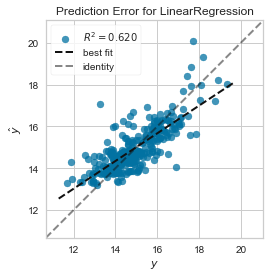

In [140]:
visualizer = prediction_error(final_model_energy_linear, np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test));


In [141]:
final_model_energy_linear.score(X_train, y_train)

0.7325781108217149

In [142]:
final_model_energy_linear.score(X_test, y_test)

0.6199721180349002

In [143]:
lasso = linear_model.Lasso()

In [144]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {'alpha':[0.02, 0.024, 0.025, 0.026, 0.03, 0.1, 0.2, 0.3,0.4, 0.5, 1, 2, 3, 4, 5]}


rnd_search = RandomizedSearchCV(lasso, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=10)
rnd_search.fit(X_train, y_train)


RandomizedSearchCV(cv=5, estimator=Lasso(),
                   param_distributions={'alpha': [0.02, 0.024, 0.025, 0.026,
                                                  0.03, 0.1, 0.2, 0.3, 0.4, 0.5,
                                                  1, 2, 3, 4, 5]},
                   random_state=10, scoring='neg_mean_squared_error')

In [145]:
lasso = rnd_search.best_estimator_

In [146]:
final_predictions_energy = lasso.predict(X_test)

In [147]:
regression_metrics(np.array(y_test), final_predictions_energy)

MAE:  0.6513
MSE:  0.71708
RMSE:  0.8468055414762636
R²:  0.55975


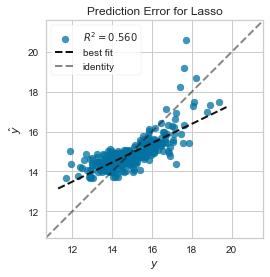

In [148]:
visualizer = prediction_error(lasso, np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test));


In [149]:
ridge = linear_model.Ridge()

In [150]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {'alpha':[200, 230, 250,265, 270, 275, 290, 300, 500]}

rnd_search = RandomizedSearchCV(ridge, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=10)
rnd_search.fit(X_train, y_train)


RandomizedSearchCV(cv=5, estimator=Ridge(),
                   param_distributions={'alpha': [200, 230, 250, 265, 270, 275,
                                                  290, 300, 500]},
                   random_state=10, scoring='neg_mean_squared_error')

In [151]:
ridge = rnd_search.best_estimator_

In [152]:
final_predictions_energy = ridge.predict(X_test)

In [153]:
regression_metrics(np.array(y_test), final_predictions_energy)

MAE:  0.68073
MSE:  0.78435
RMSE:  0.8856332630043178
R²:  0.51846


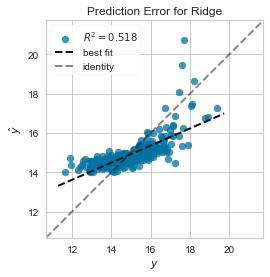

In [154]:
visualizer = prediction_error(ridge, np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test));


In [155]:
gdboost = GradientBoostingRegressor()
param_distribs = {
        "n_estimators" : [int(x) for x in np.linspace(start=200, stop=1000, num=10)],
        "max_features" : ["auto", "sqrt"],
        "max_depth": [int(x) for x in np.linspace(start=5, stop=110, num=11)],
        "min_samples_split" : randint(low=2, high=10),
        "min_samples_leaf" : randint(low=2, high=10)
    }
rnd_search = RandomizedSearchCV(gdboost, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=10)
rnd_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=GradientBoostingRegressor(),
                   param_distributions={'max_depth': [5, 15, 26, 36, 47, 57, 68,
                                                      78, 89, 99, 110],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002685F934D30>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000026861B51FA0>,
                                        'n_estimators': [200, 288, 377, 466,
                                                         555, 644, 733, 822,
                                                         911, 1000]},
                   random_state=10, scoring='neg_mean_squared_error')

In [156]:
final_model_energy_gdboost = rnd_search.best_estimator_
final_predictions_energy = final_model_energy_gdboost.predict(X_test)
regression_metrics(np.array(y_test), final_predictions_energy)

MAE:  0.46025
MSE:  0.42229
RMSE:  0.6498349560411154
R²:  0.74074


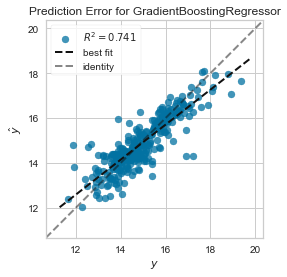

In [157]:
visualizer = prediction_error(final_model_energy_gdboost, np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test));


In [158]:
final_model_energy_gdboost.score(X_train, y_train)

0.9671498557080817

In [159]:
final_model_energy_gdboost.score(X_test, y_test)

0.7407408410376755

In [160]:
regressor = RandomForestRegressor(n_estimators = 100, random_state = 0)

# fit the regressor with x and y data
regressor.fit(X_train, y_train)

# Predict the Test set results
y_pred = regressor.predict(X_test)


In [161]:
# instanciation du modèle avec paramètre de base 
forest_reg = RandomForestRegressor(random_state=10, n_jobs=-1)

In [162]:
param_distribs = {
        "n_estimators" : [int(x) for x in np.linspace(start=200, stop=1000, num=10)],
        "max_features" : ["auto", "sqrt"],
        "max_depth": [int(x) for x in np.linspace(start=5, stop=110, num=11)],
        "min_samples_split" : randint(low=2, high=10),
        "min_samples_leaf" : randint(low=2, high=10),
        "bootstrap" : [True, False]
    }

rnd_search = RandomizedSearchCV(regressor, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=10)
rnd_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=0),
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [5, 15, 26, 36, 47, 57, 68,
                                                      78, 89, 99, 110],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000026864CCD2B0>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000026864CC5520>,
                                        'n_estimators': [200, 288, 377, 466,
                                                         555, 644, 733, 822,
                                                         911, 1000]},
                   random_state=10, scoring='neg_mean_squared_error')

In [163]:
final_model_energy_forest = rnd_search.best_estimator_
final_predictions_energy = final_model_energy_forest.predict(X_test)
regression_metrics(np.array(y_test), final_predictions_energy)

MAE:  0.43914
MSE:  0.38518
RMSE:  0.6206324499265125
R²:  0.76352


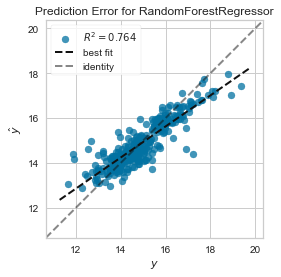

In [164]:
visualizer = prediction_error(final_model_energy_forest, np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test));


In [165]:
feature_importances_forest = pd.DataFrame(final_model_energy_forest.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)

feature_importances_gradient = pd.DataFrame(final_model_energy_gdboost.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)

In [166]:
pd.set_option("display.max_rows", None, "display.max_columns", None)
feature_importances_forest.head()

,importance
PropertyGFABuilding(s),0.23
LargestPropertyUseTypeGFA,0.20
SecondLargestPropertyUseTypeGFA,0.09
NumberofFloors,0.09
PropertyGFAParking,0.05


In [167]:
pd.set_option("display.max_rows", None, "display.max_columns", None)
feature_importances_gradient.head()

,importance
PropertyGFABuilding(s),0.27
LargestPropertyUseTypeGFA,0.21
SecondLargestPropertyUseTypeGFA,0.12
NumberofFloors,0.09
LargestPropertyUseType_2,0.03
